In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import time
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

# Use CPU for now
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device("cpu")

# Create visualization folder
os.makedirs("visualization", exist_ok=True)

# Load dataset
df = pd.read_csv("Data/borg_traces_data.csv")
print("Dataset loaded:", df.shape)


Dataset loaded: (405894, 34)


In [4]:
from sklearn.preprocessing import StandardScaler
import torch
import networkx as nx
import random

# 1. Feature selection
feature_cols = ['assigned_memory', 'page_cache_memory', 'priority', 'scheduling_class', 'instance_index']
label_col = 'failed'

# 2. Clean and scale
df_clean = df[feature_cols + ['machine_id', 'alloc_collection_id', label_col]].dropna()
df_clean.reset_index(drop=True, inplace=True)
scaler = StandardScaler()
df_clean[feature_cols] = scaler.fit_transform(df_clean[feature_cols])

# 3. Initialize graph
G = nx.Graph()
G.add_nodes_from(range(len(df_clean)))

# 4. Streaming-safe sparse edge sampling
def add_random_edges_safe(group_dict, max_edges=500):
    for group_nodes in group_dict.values():
        group_nodes = list(group_nodes)
        if len(group_nodes) < 2:
            continue
        edges = set()
        attempts = 0
        while len(edges) < max_edges and attempts < max_edges * 5:
            a, b = random.sample(group_nodes, 2)
            edge = tuple(sorted((a, b)))
            if edge not in edges:
                edges.add(edge)
            attempts += 1
        G.add_edges_from(edges)

# Add sparse edges by machine_id and alloc_collection_id
add_random_edges_safe(df_clean.groupby('machine_id').groups)
add_random_edges_safe(df_clean.groupby('alloc_collection_id').groups)

# 5. Features and labels
node_features = torch.tensor(df_clean[feature_cols].values, dtype=torch.float)
node_labels = torch.tensor(df_clean[label_col].values, dtype=torch.long)

print(f"✅ Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


✅ Graph built with 405894 nodes and 809466 edges


In [5]:
from torch_geometric.data import Data
import torch
import numpy as np

# Convert graph to edge_index format
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

# Create PyG Data object
graph_data = Data(x=node_features, edge_index=edge_index, y=node_labels)

# Generate train/val/test masks
num_nodes = graph_data.num_nodes
perm = torch.randperm(num_nodes)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_idx = perm[:int(train_ratio * num_nodes)]
val_idx = perm[int(train_ratio * num_nodes):int((train_ratio + val_ratio) * num_nodes)]
test_idx = perm[int((train_ratio + val_ratio) * num_nodes):]

graph_data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

graph_data.train_mask[train_idx] = True
graph_data.val_mask[val_idx] = True
graph_data.test_mask[test_idx] = True

print("✅ PyG Data object ready")
print(f"Nodes: {num_nodes}, Edges: {graph_data.num_edges}")
print(f"Train: {graph_data.train_mask.sum().item()}, Val: {graph_data.val_mask.sum().item()}, Test: {graph_data.test_mask.sum().item()}")


✅ PyG Data object ready
Nodes: 405894, Edges: 809466
Train: 284125, Val: 60884, Test: 60885


In [8]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import time

# Define model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate
model = GCN(in_channels=graph_data.num_features, hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(1, 501):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = F.nll_loss(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = out[graph_data.val_mask]
        val_pred = val_out.argmax(dim=1)
        val_acc = (val_pred == graph_data.y[graph_data.val_mask]).sum().item() / graph_data.val_mask.sum().item()
        val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: Loss = {loss.item():.4f}, Val Acc = {val_acc:.4f}")

training_time = time.time() - start_time
print(f"\n✅ Training complete in {training_time:.2f} seconds")


Epoch 001: Loss = 0.6422, Val Acc = 0.6630
Epoch 010: Loss = 0.5667, Val Acc = 0.7677
Epoch 020: Loss = 0.5538, Val Acc = 0.7692
Epoch 030: Loss = 0.5484, Val Acc = 0.7709
Epoch 040: Loss = 0.5446, Val Acc = 0.7707
Epoch 050: Loss = 0.5422, Val Acc = 0.7710
Epoch 060: Loss = 0.5406, Val Acc = 0.7710
Epoch 070: Loss = 0.5397, Val Acc = 0.7711
Epoch 080: Loss = 0.5390, Val Acc = 0.7711
Epoch 090: Loss = 0.5382, Val Acc = 0.7711
Epoch 100: Loss = 0.5376, Val Acc = 0.7711
Epoch 110: Loss = 0.5374, Val Acc = 0.7711
Epoch 120: Loss = 0.5370, Val Acc = 0.7711
Epoch 130: Loss = 0.5366, Val Acc = 0.7711
Epoch 140: Loss = 0.5365, Val Acc = 0.7711
Epoch 150: Loss = 0.5361, Val Acc = 0.7711
Epoch 160: Loss = 0.5359, Val Acc = 0.7711
Epoch 170: Loss = 0.5358, Val Acc = 0.7711
Epoch 180: Loss = 0.5356, Val Acc = 0.7711
Epoch 190: Loss = 0.5353, Val Acc = 0.7711
Epoch 200: Loss = 0.5352, Val Acc = 0.7711
Epoch 210: Loss = 0.5352, Val Acc = 0.7712
Epoch 220: Loss = 0.5349, Val Acc = 0.7711
Epoch 230: 

✅ Test Set Evaluation
Confusion Matrix:
 [[46925    17]
 [13895    48]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7715    0.9996    0.8709     46942
           1     0.7385    0.0034    0.0069     13943

    accuracy                         0.7715     60885
   macro avg     0.7550    0.5015    0.4389     60885
weighted avg     0.7640    0.7715    0.6730     60885

ROC AUC Score: 0.5434348021257831


<Figure size 640x480 with 0 Axes>

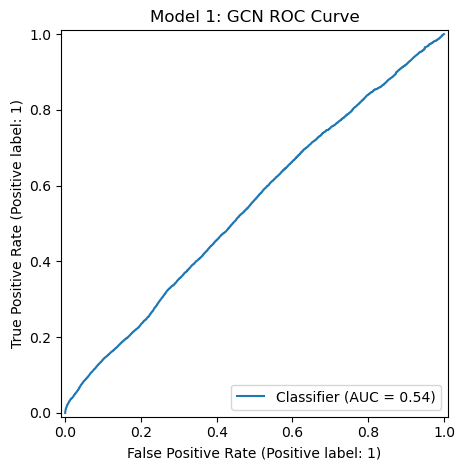

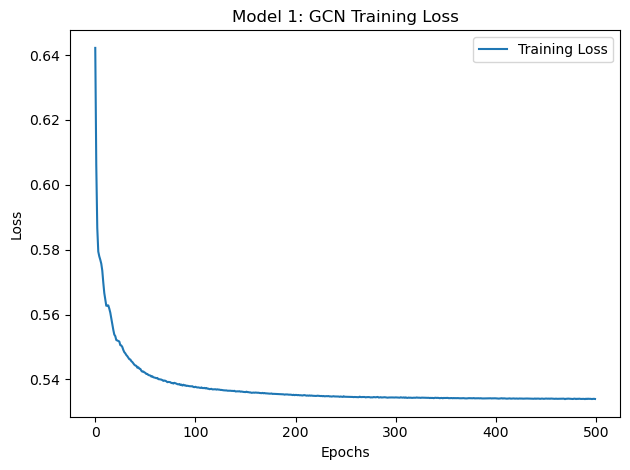

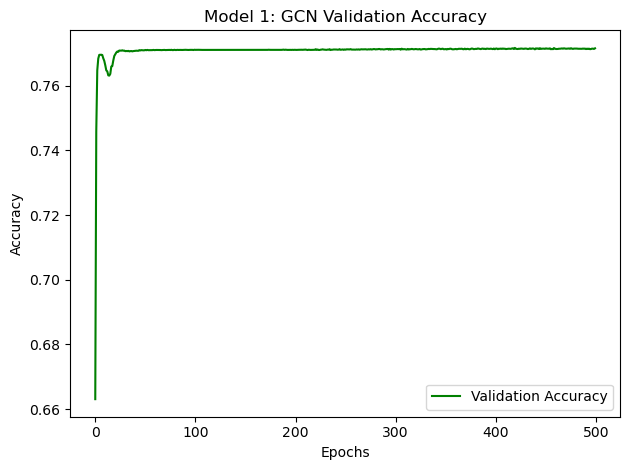

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Set model to evaluation
model.eval()
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    test_out = out[graph_data.test_mask]
    test_pred = test_out.argmax(dim=1)
    y_true = graph_data.y[graph_data.test_mask].cpu().numpy()
    y_pred = test_pred.cpu().numpy()
    y_proba = test_out.exp()[:, 1].cpu().numpy()  # class 1 probabilities

# Metrics
print("✅ Test Set Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

# Plot and save ROC curve
plt.figure()
RocCurveDisplay.from_predictions(y_true, y_proba)
plt.title("Model 1: GCN ROC Curve")
plt.tight_layout()
plt.savefig("visualization/model1_roc_curve.png", dpi=300)
plt.show()

# Training curve: loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model 1: GCN Training Loss")
plt.legend()
plt.tight_layout()
plt.savefig("visualization/model1_training_loss.png", dpi=300)
plt.show()

# Training curve: accuracy
plt.figure()
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 1: GCN Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("visualization/model1_val_accuracy.png", dpi=300)
plt.show()


In [16]:
from torch_geometric.nn import GNNExplainer
import random
import matplotlib.pyplot as plt

# Choose a node from the test set
test_nodes = torch.where(graph_data.test_mask)[0].tolist()
node_to_explain = random.choice(test_nodes)
print(f"🔍 Explaining node {node_to_explain}")

# Create explainer using legacy API (no epochs in __init__)
explainer = GNNExplainer(model, log=True)

# Explain the node (older API: explain())
node_feat_mask, edge_mask = explainer.explain(node_to_explain, graph_data.x, graph_data.edge_index)

# Visualize important subgraph
ax, G_sub = explainer.visualize_subgraph(node_to_explain, graph_data.edge_index, edge_mask)
plt.title(f"GCN Important Edges — Node {node_to_explain}")
plt.tight_layout()
graph_path = f"visualization/model1_node{node_to_explain}_important_edges_legacy.png"
plt.savefig(graph_path, dpi=300)
plt.show()

# Visualize important features
plt.figure(figsize=(8, 4))
plt.bar(range(graph_data.num_features), node_feat_mask.detach().numpy())
plt.xticks(range(graph_data.num_features), feature_cols, rotation=45, ha='right')
plt.title(f"GCN Feature Importance — Node {node_to_explain}")
plt.tight_layout()
feature_path = f"visualization/model1_node{node_to_explain}_feature_importance_legacy.png"
plt.savefig(feature_path, dpi=300)
plt.show()

print("✅ Node explanation complete and saved:")
print(f" - {graph_path}")
print(f" - {feature_path}")


ImportError: cannot import name 'GNNExplainer' from 'torch_geometric.nn' (c:\Users\binwa\anaconda3\Lib\site-packages\torch_geometric\nn\__init__.py)